# StockMarketPrediction

## Data Manipulation

### Connecting to Database

In [1]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(create_table_sql, conn):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
conn = create_connection("normalized_ppg6.db")

In [4]:
def query_table(sql_query, connx=conn, ret=True):
    testdf = execute_sql_statement(sql_query, connx)
    if ret:
        return(testdf)
    else:
        display(testdf)

### Creating Analytical Dataset

In [5]:
sql_statement = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
query_table(sql_statement,ret=True)

[('AAPL_5Y',),
 ('AMZN_5Y',),
 ('Company',),
 ('FB_5Y',),
 ('GOOG_5Y',),
 ('NFLX_5Y',),
 ('TSLA_5Y',)]

In [6]:
sql_statement = """CREATE TABLE HistoricalPrices AS
SELECT * FROM
(SELECT 'AAPL' AS StockSymbol, * FROM AAPL_5Y
UNION ALL
SELECT 'AMZN' AS StockSymbol, * FROM AMZN_5Y
UNION ALL
SELECT 'FB' AS StockSymbol, * FROM FB_5Y
UNION ALL
SELECT 'GOOG' AS StockSymbol, * FROM GOOG_5Y
UNION ALL
SELECT 'NFLX' AS StockSymbol, * FROM NFLX_5Y);"""
create_table(sql_statement, conn)

## Data Exploration

## Time-Series Analysis

### Exploring Time Components

In [97]:
import os
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

*For our time series analysis, we only need the close price at daily level. So for a particular chosen company (AMZN), we will run the detailed analysis. At the end of the analysis, we will functionalize the analysis to be easily applied for any chosen stock.*

In [102]:
tbl_close = query_table("""SELECT Date, Close FROM HistoricalPrices 
WHERE StockSymbol='AMZN' """)

df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
df_close['Date'] = pd.to_datetime(df_close['Date'])
df_close.set_index('Date', inplace=True)
display(df_close)

,Close
Date,
2016-12-12,760.119995
2016-12-13,774.340027
2016-12-14,768.820007
2016-12-15,761.000000
2016-12-16,757.770020
...,...
2021-12-06,3427.370117
2021-12-07,3523.290039
2021-12-08,3523.159912


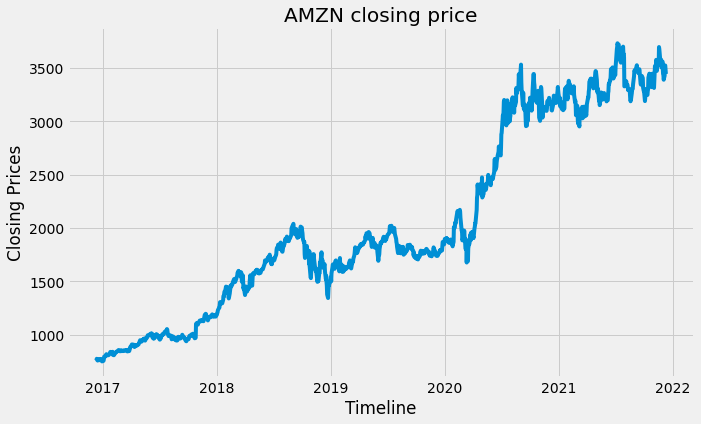

In [126]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df_close['Close'])
plt.title('AMZN closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

<Figure size 720x432 with 0 Axes>

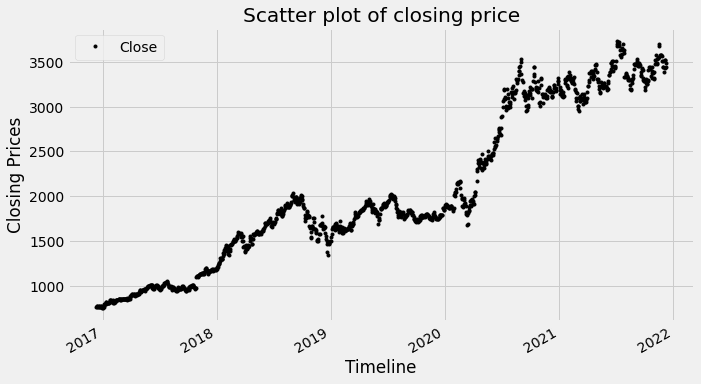

In [125]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.show()

<Figure size 720x432 with 0 Axes>

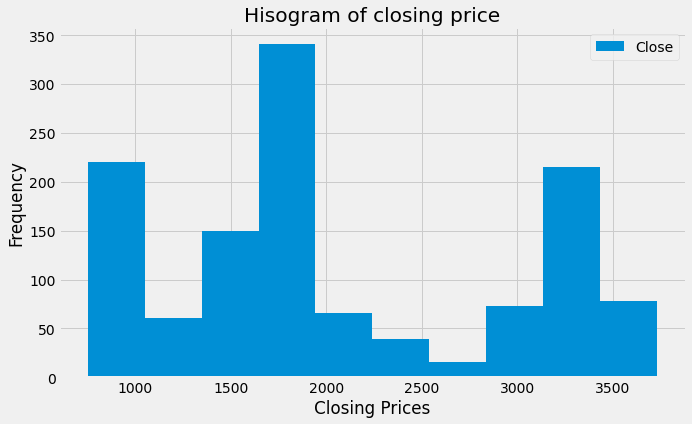

In [124]:
plt.figure(figsize=(10,6))
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.xlabel('Closing Prices')
plt.show()

#### Testing For Stationarity:

Ho: It is non-stationary
H1: It is stationary

> If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

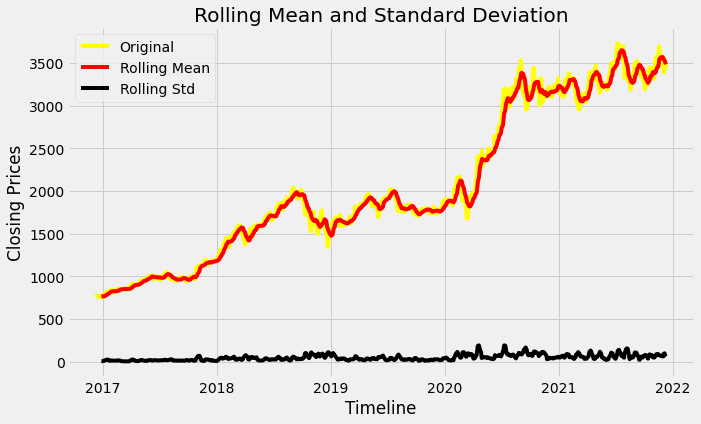

Results of dickey fuller test
Test Statistics                  -0.643743
p-value                           0.860788
No. of lags used                  3.000000
Number of observations used    1255.000000
critical value (1%)              -3.435571
critical value (5%)              -2.863846
critical value (10%)             -2.567998
dtype: float64


In [123]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_hist['Close'])

`Inference: p-value is greater than 0.05, so we cannot reject the Null hypothesis and the series is non-stationary`

To achieve stationarity, we will seperate Trend and Seasonality components from the time series

<Figure size 720x432 with 0 Axes>

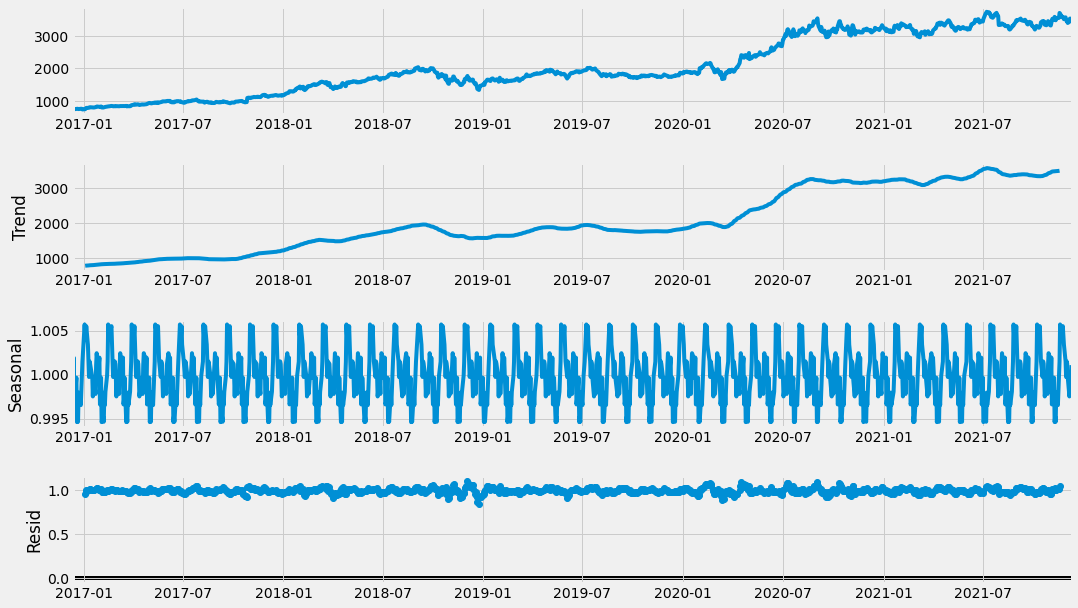

In [74]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

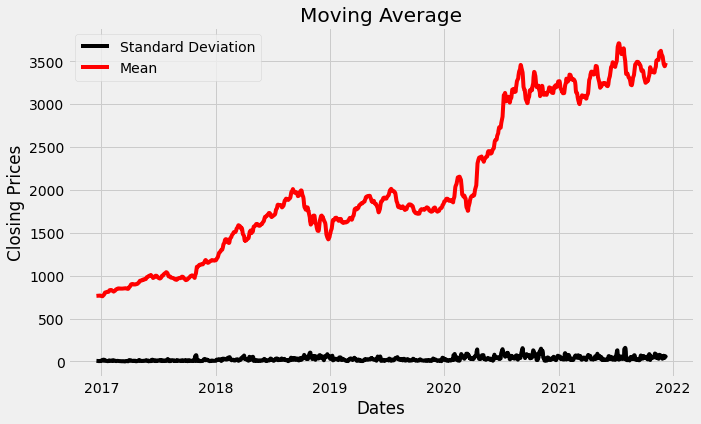

In [118]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
moving_avg = df_close.rolling(5).mean()
std_dev = df_close.rolling(5).std()
plt.title('Moving Average')
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### ARIMA Modeling

#### Training:

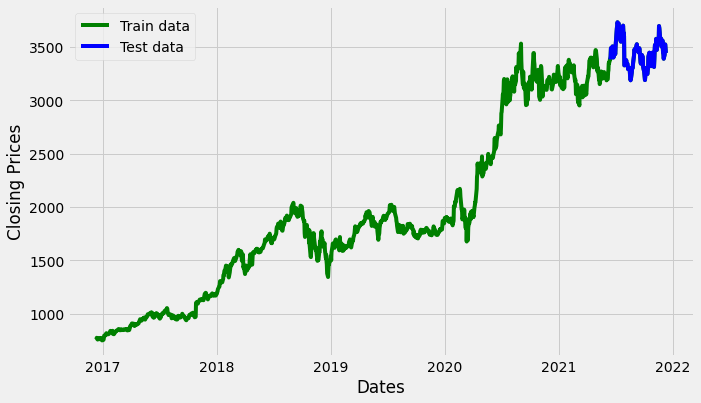

In [90]:
#split data into train and training set
split_ratio = 0.9
train_len = int(len(df_close)*split_ratio)
train_data, test_data = df_close[:train_len], df_close[train_len:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Timeline')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [92]:
def arimamodel(timeseries):
    automodel = auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf", # use adftest to find optimal 'd'
                              seasonal=False, # No Seasonality
                              trace=True)
    return automodel

In [119]:
def plot_arima(n_periods, timeseries, automodel, test_series=None):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Business Day index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="B")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, label="Past Data")
    if test_series is not None:
        plt.plot(test_series, color='blue', label='Actual Stock Price')
    plt.plot(fc_series, color='red', label ='Predicted Stock Price')
    plt.xlabel('Timeline')
    plt.ylabel('Closing Prices')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25,
                    label ="95% confidence interval")
    plt.legend(loc='upper left')
    plt.show()

In [94]:
def score_arima(n_periods, test_timeseries, automodel):
    fc = automodel.predict(n_periods=n_periods)
    
    mse = mean_squared_error(test_timeseries, fc)
    print(f'MSE: {mse} ({mse:.2%})')
    mae = mean_absolute_error(test_timeseries, fc)
    print(f'MAE: {mae} ({mae:.2%})')
    rmse = math.sqrt(mean_squared_error(test_timeseries, fc))
    print(f'RMSE: {rmse} ({rmse:.2%})')
    mape = np.mean(np.abs(fc - test_timeseries)/np.abs(test_timeseries))
    print(f'MAPE: {mape} ({mape:.2%})')
    
    return None

In [95]:
automodel = arimamodel(train_data)
print(automodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11569.417, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11571.927, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11569.866, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11569.890, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11573.708, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11571.399, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11571.392, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11571.891, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11571.823, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11569.793, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=11571.494, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.962 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

So the Auto ARIMA model provided the value of p,d, and q as 1, 1 and 1 respectively.

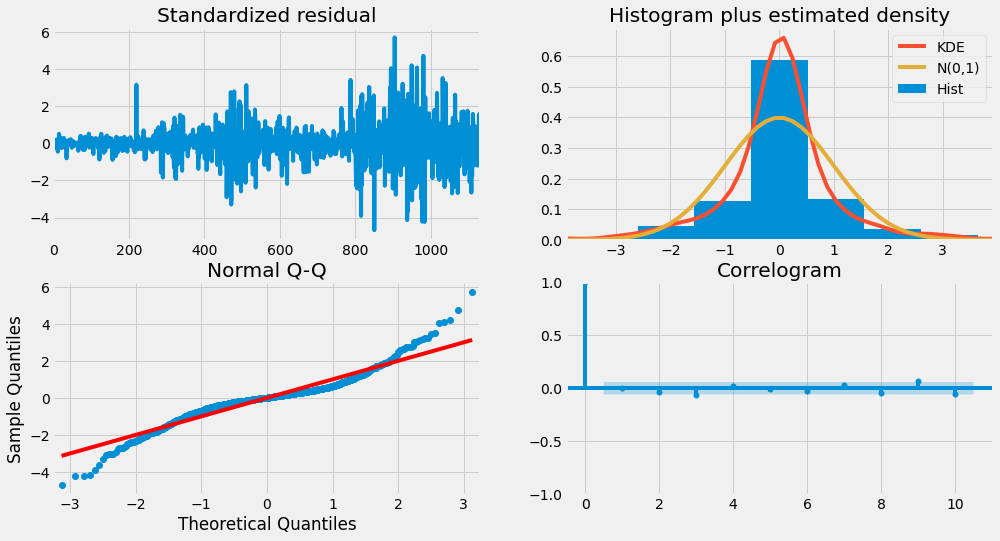

In [96]:
automodel.plot_diagnostics(figsize=(15,8))
plt.show()

#### Testing:

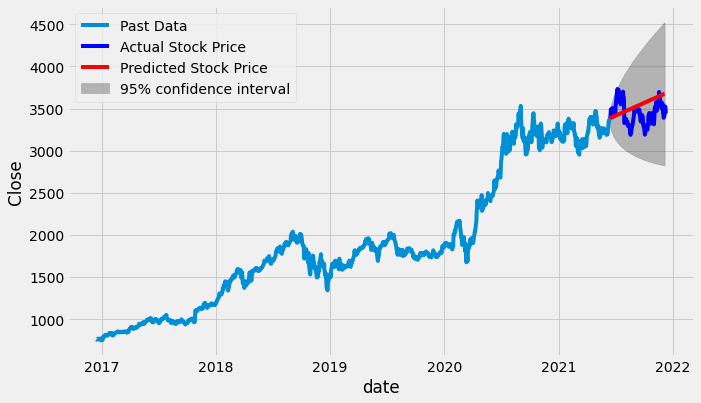

In [63]:
plot_arima(126, train_data, automodel, test_series=test_data)

#### Model Performance:

In [47]:
score_arima(126, test_data, automodel)

MSE: 33927.7397576699 (3392773.98%)
MAE: 160.7122803581748 (16071.23%)
RMSE: 184.19484183241914 (18419.48%)
MAPE: 0.04710223746135646 (4.71%)


Around 4.7% MAPE(Mean Absolute Percentage Error) implies the model is about 95.3% accurate in predicting the test set observations.

### Price Forecasting:

Using the above fitted model, now we can forecast the stock price for next month (30 Business days)

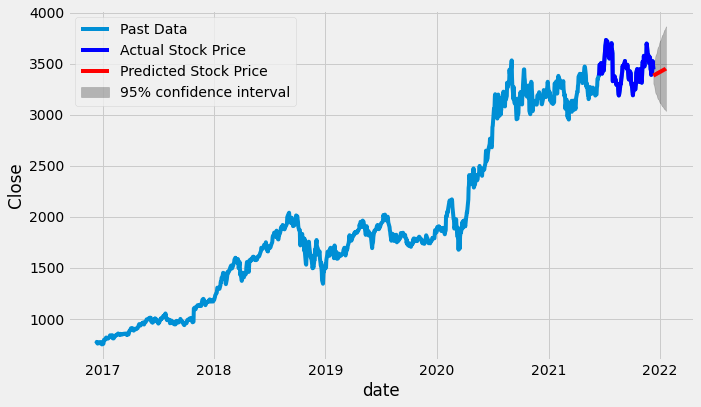

In [49]:
plot_arima(30, df_close, automodel)

#### Appendix:

In [120]:
def closeprice_data(company_symbol='AAPL'):
    tbl_close = query_table(f"""SELECT Date, Close FROM HistoricalPrices 
        WHERE StockSymbol='{company_symbol}' """)

    df_close = pd.DataFrame(tbl_close, columns = ['Date','Close'])
    df_close['Date'] = pd.to_datetime(df_close['Date'])
    df_close.set_index('Date', inplace=True)
    #display(df_close)
    return (df_close)

In [121]:
def generalized_arima(n_periods, symbol):
    timeseries = closeprice_data('AAPL')
    glamodel = arimamodel(timeseries)
    plot_arima(n_periods, timeseries, glamodel)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8634.110, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8630.183, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8632.110, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8632.110, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8628.246, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.228 seconds


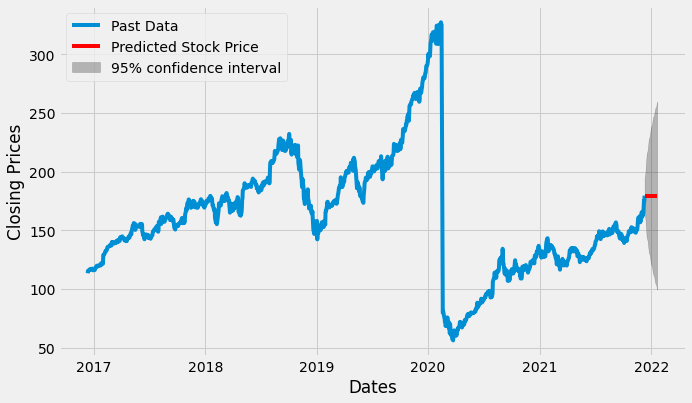

In [130]:
generalized_arima(30, 'AMZN')